# Task 4: Predictive Modeling & Risk Pricing

## Goal
Build and evaluate predictive models to form the core of a dynamic, risk-based pricing system.

1. **Claim Probability Model (Classification)**: Predict chance of a claim.
2. **Claim Severity Model (Regression)**: Predict cost of a claim (if it occurs).


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb

# Add src to path
sys.path.append(os.path.abspath(os.path.join('..')))

from src.loader import load_data
from src.cleaning import clean_data

## 1. Data Preparation

In [7]:
# Load and Clean Data
filepath = '../data/MachineLearningRating_v3.txt'
df = load_data(filepath)
df_clean = clean_data(df)

# Construct Target Variables
df_clean['ClaimFrequency'] = (df_clean['TotalClaims'] > 0).astype(int)

# Select Features (simplified for demonstration, expand as needed)
categorical_cols = ['Province', 'PostalCode', 'Gender', 'VehicleType', 'make', 'bodytype']

# Ensure all categorical columns are strings to avoid mixed types with 'Other' or OneHotEncoder errors
df_clean[categorical_cols] = df_clean[categorical_cols].astype(str)
numeric_cols = ['SumInsured', 'CalculatedPremiumPerTerm'] # Add other numeric cols if available

# NOTE: PostalCode and Make have high cardinality, might need better handling (e.g. Target Encoding) later.
# For now, we will limit to top N categories for speed or standard encoding.

# Reduce cardinality for high-cardinality columns for this simplified run
top_n = 10
for col in ['PostalCode', 'make', 'bodytype']:
    top_cats = df_clean[col].value_counts().nlargest(top_n).index
    df_clean[col] = df_clean[col].apply(lambda x: x if x in top_cats else 'Other')

X = df_clean[categorical_cols + numeric_cols]
y_class = df_clean['ClaimFrequency']
y_reg = df_clean['TotalClaims']

# Preprocessing Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Split Data (Stratified for Classification)
X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42, stratify=y_class)

print("Training Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)


Successfully loaded data from ../data/MachineLearningRating_v3.txt with shape (1000098, 52)


c:\KAIM\week-3\src\cleaning.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')


Training Set Shape: (800078, 8)
Test Set Shape: (200020, 8)


## 2. Model 1: Claim Probability (Classification)

In [8]:
# Define Models
models_class = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results_class = []

for name, model in models_class.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    
    pipeline.fit(X_train, y_train_class)
    y_pred = pipeline.predict(X_test)
    
    acc = accuracy_score(y_test_class, y_pred)
    prec = precision_score(y_test_class, y_pred, zero_division=0)
    rec = recall_score(y_test_class, y_pred)
    f1 = f1_score(y_test_class, y_pred)
    
    results_class.append({'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1})
    
pd.DataFrame(results_class)

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [10:24:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.99720,0.0,0.0,0.0
1,Random Forest,0.99721,0.0,0.0,0.0
2,XGBoost,0.99721,0.0,0.0,0.0


## 3. Model 2: Claim Severity (Regression)
Building model only on claims > 0.

In [9]:
# Filter data for regression (only positive claims)
mask_claims = df_clean['TotalClaims'] > 0
X_reg = X[mask_claims]
y_reg_target = y_reg[mask_claims]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg_target, test_size=0.2, random_state=42)

models_reg = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

results_reg = []

for name, model in models_reg.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    
    pipeline.fit(X_train_reg, y_train_reg)
    y_pred = pipeline.predict(X_test_reg)
    
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
    r2 = r2_score(y_test_reg, y_pred)
    
    results_reg.append({'Model': name, 'RMSE': rmse, 'R2 Score': r2})

pd.DataFrame(results_reg)

,Model,RMSE,R2 Score
0,Linear Regression,36848.557097,0.155717
1,Random Forest,35466.448327,0.217864
2,XGBoost,36944.731771,0.151304


## 4. SHAP Interpretability (Best Model)
Analyzing feature importance using the best Regression model (Likely XGBoost or RF).

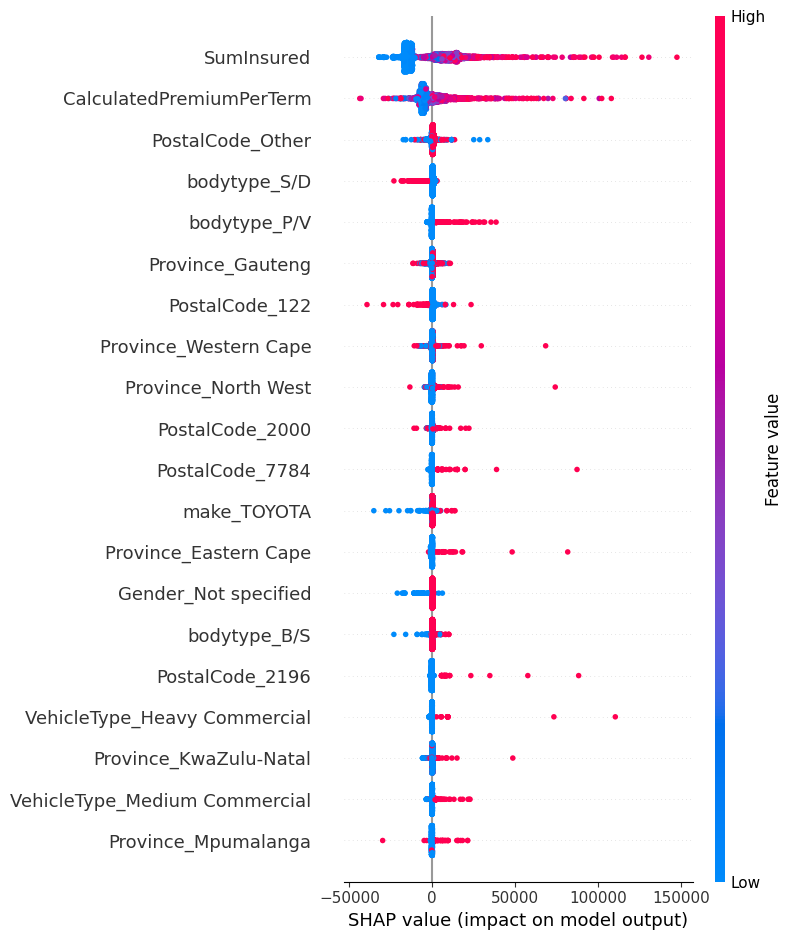

In [10]:
# Train simple XGBoost for SHAP (bypassing full pipeline for easier shap handling setup)
# Transform data first
X_transformed = preprocessor.fit_transform(X_reg)
feature_names = (numeric_cols + 
                 list(preprocessor.named_transformers_['cat']
                      .named_steps['encoder']
                      .get_feature_names_out(categorical_cols)))

model_xgb = xgb.XGBRegressor(random_state=42)
model_xgb.fit(X_transformed, y_reg_target)

# Explain
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_transformed)

# Plot
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)